In [10]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

Modified timestamps for file u00001s00001_hw00001.svc:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32




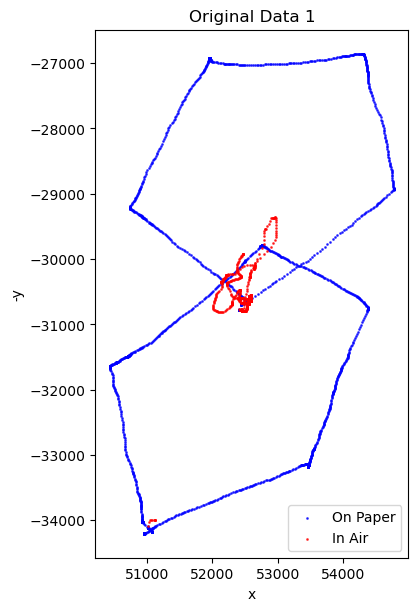

Number of processed files: 1
Average number of data points: 3444


In [11]:
# Cell 2

def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        # Plot with a 90-degree right rotation (swap x and y)
        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(on_paper['x'], -on_paper['y'], c='blue', s=1, alpha=0.7, label='On Paper')  # Swap x and y, negate y
        axs[i].scatter(in_air['x'], -in_air['y'], c='red', s=1, alpha=0.7, label='In Air')  # Swap x and y, negate y
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('x')  # x-axis is 'x'
        axs[i].set_ylabel('-y')  # y-axis is '-y'
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

directory = 'Try2'  # Directory where the .svc files are stored
num_files_to_use = 1
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [12]:
# Cell 3
# Process each DataFrame instead of just the first one
for df_idx in range(len(data_frames)):
    df = data_frames[df_idx]  # Using each DataFrame in the list

    # Convert the 'timestamp' column to numeric for calculations (if not already done)
    df['timestamp'] = pd.to_numeric(df['timestamp'])

    # Sort the DataFrame by timestamp (should already be sorted in the function)
    df.sort_values('timestamp', inplace=True)

    # Calculate the differences between consecutive timestamps (optional for gap finding)
    df['time_diff'] = df['timestamp'].diff()

    # Identify the indices where the time difference is greater than 30,000 milliseconds
    gap_indices = df.index[df['time_diff'] > 8].tolist()

    # Create an empty list to hold the new rows
    new_rows = []

    # Fill in the gaps with 70 milliseconds intervals
    for idx in gap_indices:
        # Check if the next index is valid
        if idx + 1 < len(df):
            # Get the current and next timestamps
            current_timestamp = df.at[idx, 'timestamp']
            next_timestamp = df.at[idx + 1, 'timestamp']

            # Calculate how many entries we need to fill in
            num_fill_entries = (next_timestamp - current_timestamp) // 7

            # Generate the timestamps to fill the gap
            for i in range(1, num_fill_entries + 1):
                new_timestamp = current_timestamp + i * 7

                # Create a new row to fill in with NaN for x and y
                new_row = {
                    'x': np.nan,  # Set x to NaN
                    'y': np.nan,  # Set y to NaN
                    'timestamp': new_timestamp,
                    'pen_status': 0,        # You can set this to your desired value
                    'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                    'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                    'pressure': df.at[idx, 'pressure']  # Use the current pressure value
                }

                # Append the new row to the list of new rows
                new_rows.append(new_row)

    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the original DataFrame with the new rows DataFrame
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Sort the DataFrame by timestamp to maintain order
    df.sort_values('timestamp', inplace=True)

    # Reset index after sorting
    df.reset_index(drop=True, inplace=True)

    # Interpolate NaN values in 'x' and 'y' columns based on nearest neighbors
    # Check for NaN entries before interpolation
    if df[['x', 'y']].isnull().any().any():
        df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

    # Drop the 'time_diff' column after processing
    df.drop(columns=['time_diff'], inplace=True)

    # Update the processed data
    data_frames[df_idx] = df

# Update processed data for all DataFrames
processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                  for df, scaler in zip(data_frames, scalers)]
avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

In [13]:

# Cell 4
processed_dataframes = []

for input_filename, df in zip(input_filenames, data_frames):
    # Convert all numeric columns to integers
    df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']] = df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']].astype(int)
    
    # Append the processed DataFrame to the list
    processed_dataframes.append(df)

    print(f"Processed DataFrame for: {input_filename}")



Processed DataFrame for: u00001s00001_hw00001.svc


In [14]:
# Cell 5 (modified, no visualization)
def process_dataframes(dataframes, num_files_to_use=None):
    if num_files_to_use:
        dataframes = dataframes[:num_files_to_use]

    data_frames = []
    scalers = []

    for i, df in enumerate(dataframes):
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for DataFrame {i + 1}:")
        print(df['timestamp'].head())
        print("\n")

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, [f"DataFrame_{i+1}" for i in range(len(dataframes))]

# Use the processed_dataframes directly
data_frames, processed_data, scalers, avg_data_points, original_filenames = process_dataframes(processed_dataframes, num_files_to_use)
print(f"Number of processed files: {len(processed_data)}")
# print(f"Average number of data points: {avg_data_points}")


Modified timestamps for DataFrame 1:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32


Number of processed files: 1


In [15]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, **kwargs):  # Added **kwargs to handle extra arguments
        super(VAE, self).__init__(**kwargs)  # Pass kwargs to the parent class
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        # Handle any unexpected keys like 'trainable' by removing them
        config.pop('trainable', None)
        config.pop('dtype', None)  # Also remove 'dtype' if included
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        # Add the VAE-specific arguments
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 512
beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [16]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        
        # Retain original columns for pressure, azimuth, and altitude
        original_data = data_frames[i % num_input_files]  # Use original unprocessed data
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        # Determine the number of points for this augmented dataset
        # num_points = int(avg_data_points * (1 + np.random.uniform(-length_variability, length_variability)))
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        # Encode and reparameterize
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()
        
        # # Adjust number of points
        # if num_points > augmented_data.shape[0]:
        #     extra_indices = np.random.choice(augmented_data.shape[0], num_points - augmented_data.shape[0])
        #     augmented_data = np.vstack((augmented_data, augmented_data[extra_indices]))
        # elif num_points < augmented_data.shape[0]:
        #     keep_indices = np.random.choice(augmented_data.shape[0], num_points, replace=False)
        #     augmented_data = augmented_data[keep_indices]

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        # Append the pressure, azimuth, and altitude columns from the original data
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/100: 100%|██████████| 8/8 [00:27<00:00,  3.44s/batch, Generator Loss=0.653, Reconstruction Loss=0.653, KL Loss=0.000654]


Epoch 1: Generator Loss = 0.714895, Reconstruction Loss = 0.714895, KL Divergence Loss = 0.000332
NRMSE = 0.318170


Epoch 2/100: 100%|██████████| 8/8 [00:01<00:00,  7.62batch/s, Generator Loss=0.639, Reconstruction Loss=0.639, KL Loss=0.00351] 


Epoch 2: Generator Loss = 0.660255, Reconstruction Loss = 0.660255, KL Divergence Loss = 0.001863
NRMSE = 0.300937


Epoch 3/100: 100%|██████████| 8/8 [00:01<00:00,  4.64batch/s, Generator Loss=0.431, Reconstruction Loss=0.431, KL Loss=0.0203] 


Epoch 3: Generator Loss = 0.527597, Reconstruction Loss = 0.527597, KL Divergence Loss = 0.010592
NRMSE = 0.300544


Epoch 4/100: 100%|██████████| 8/8 [00:01<00:00,  6.94batch/s, Generator Loss=0.248, Reconstruction Loss=0.248, KL Loss=0.0667]


Epoch 4: Generator Loss = 0.326098, Reconstruction Loss = 0.326098, KL Divergence Loss = 0.044597
NRMSE = 0.299853


Epoch 5/100: 100%|██████████| 8/8 [00:00<00:00,  8.84batch/s, Generator Loss=0.125, Reconstruction Loss=0.125, KL Loss=0.111] 


Epoch 5: Generator Loss = 0.173631, Reconstruction Loss = 0.173631, KL Divergence Loss = 0.092752
NRMSE = 0.309248


Epoch 6/100: 100%|██████████| 8/8 [00:00<00:00,  8.26batch/s, Generator Loss=0.0912, Reconstruction Loss=0.0912, KL Loss=0.14] 


Epoch 6: Generator Loss = 0.099396, Reconstruction Loss = 0.099396, KL Divergence Loss = 0.128854
NRMSE = 0.318764


Epoch 7/100: 100%|██████████| 8/8 [00:01<00:00,  5.17batch/s, Generator Loss=0.0909, Reconstruction Loss=0.0909, KL Loss=0.164]


Epoch 7: Generator Loss = 0.090188, Reconstruction Loss = 0.090188, KL Divergence Loss = 0.157904
NRMSE = 0.309150


Epoch 8/100: 100%|██████████| 8/8 [00:00<00:00,  8.02batch/s, Generator Loss=0.0829, Reconstruction Loss=0.0829, KL Loss=0.178]


Epoch 8: Generator Loss = 0.082931, Reconstruction Loss = 0.082931, KL Divergence Loss = 0.176836
NRMSE = 0.302545


Epoch 9/100: 100%|██████████| 8/8 [00:00<00:00,  8.02batch/s, Generator Loss=0.0733, Reconstruction Loss=0.0733, KL Loss=0.222]


Epoch 9: Generator Loss = 0.074998, Reconstruction Loss = 0.074998, KL Divergence Loss = 0.197236
NRMSE = 0.303269


Epoch 10/100: 100%|██████████| 8/8 [00:01<00:00,  6.10batch/s, Generator Loss=0.0516, Reconstruction Loss=0.0516, KL Loss=0.298]


Epoch 10: Generator Loss = 0.059482, Reconstruction Loss = 0.059482, KL Divergence Loss = 0.261222
NRMSE = 0.304926


Epoch 11/100: 100%|██████████| 8/8 [00:01<00:00,  7.00batch/s, Generator Loss=0.0427, Reconstruction Loss=0.0427, KL Loss=0.394]


Epoch 11: Generator Loss = 0.044785, Reconstruction Loss = 0.044785, KL Divergence Loss = 0.356201
NRMSE = 0.302519


Epoch 12/100: 100%|██████████| 8/8 [00:00<00:00,  8.04batch/s, Generator Loss=0.0374, Reconstruction Loss=0.0374, KL Loss=0.468]


Epoch 12: Generator Loss = 0.038868, Reconstruction Loss = 0.038868, KL Divergence Loss = 0.427973
NRMSE = 0.301315


Epoch 13/100: 100%|██████████| 8/8 [00:00<00:00,  8.29batch/s, Generator Loss=0.0317, Reconstruction Loss=0.0317, KL Loss=0.384]


Epoch 13: Generator Loss = 0.035060, Reconstruction Loss = 0.035060, KL Divergence Loss = 0.436668
NRMSE = 0.300772


Epoch 14/100: 100%|██████████| 8/8 [00:01<00:00,  5.90batch/s, Generator Loss=0.0288, Reconstruction Loss=0.0288, KL Loss=0.445]


Epoch 14: Generator Loss = 0.030710, Reconstruction Loss = 0.030709, KL Divergence Loss = 0.429792
NRMSE = 0.299828


Epoch 15/100: 100%|██████████| 8/8 [00:01<00:00,  7.98batch/s, Generator Loss=0.0253, Reconstruction Loss=0.0253, KL Loss=0.476]


Epoch 15: Generator Loss = 0.026768, Reconstruction Loss = 0.026768, KL Divergence Loss = 0.446804
NRMSE = 0.299960


Epoch 16/100: 100%|██████████| 8/8 [00:01<00:00,  4.71batch/s, Generator Loss=0.0193, Reconstruction Loss=0.0193, KL Loss=0.471]


Epoch 16: Generator Loss = 0.021492, Reconstruction Loss = 0.021492, KL Divergence Loss = 0.478625
NRMSE = 0.299199


Epoch 17/100: 100%|██████████| 8/8 [00:01<00:00,  7.58batch/s, Generator Loss=0.0161, Reconstruction Loss=0.0161, KL Loss=0.524]


Epoch 17: Generator Loss = 0.016618, Reconstruction Loss = 0.016617, KL Divergence Loss = 0.523918
NRMSE = 0.299175


Epoch 18/100: 100%|██████████| 8/8 [00:01<00:00,  7.71batch/s, Generator Loss=0.013, Reconstruction Loss=0.013, KL Loss=0.56]   


Epoch 18: Generator Loss = 0.013946, Reconstruction Loss = 0.013946, KL Divergence Loss = 0.584966
NRMSE = 0.298825


Epoch 19/100: 100%|██████████| 8/8 [00:00<00:00,  8.73batch/s, Generator Loss=0.0129, Reconstruction Loss=0.0129, KL Loss=0.677]


Epoch 19: Generator Loss = 0.012683, Reconstruction Loss = 0.012682, KL Divergence Loss = 0.638857
NRMSE = 0.298490


Epoch 20/100: 100%|██████████| 8/8 [00:00<00:00,  9.22batch/s, Generator Loss=0.0101, Reconstruction Loss=0.0101, KL Loss=0.69] 


Epoch 20: Generator Loss = 0.010800, Reconstruction Loss = 0.010800, KL Divergence Loss = 0.675816
NRMSE = 0.298187


Epoch 21/100: 100%|██████████| 8/8 [00:00<00:00,  8.52batch/s, Generator Loss=0.00825, Reconstruction Loss=0.00825, KL Loss=0.733]


Epoch 21: Generator Loss = 0.008843, Reconstruction Loss = 0.008842, KL Divergence Loss = 0.726865
NRMSE = 0.300500


Epoch 22/100: 100%|██████████| 8/8 [00:00<00:00,  9.88batch/s, Generator Loss=0.00667, Reconstruction Loss=0.00667, KL Loss=0.798]


Epoch 22: Generator Loss = 0.007418, Reconstruction Loss = 0.007417, KL Divergence Loss = 0.781913
NRMSE = 0.300264


Epoch 23/100: 100%|██████████| 8/8 [00:00<00:00,  8.25batch/s, Generator Loss=0.00594, Reconstruction Loss=0.00594, KL Loss=0.929]


Epoch 23: Generator Loss = 0.006412, Reconstruction Loss = 0.006411, KL Divergence Loss = 0.844019
NRMSE = 0.298424


Epoch 24/100: 100%|██████████| 8/8 [00:00<00:00,  9.12batch/s, Generator Loss=0.00481, Reconstruction Loss=0.00481, KL Loss=0.929]


Epoch 24: Generator Loss = 0.005688, Reconstruction Loss = 0.005687, KL Divergence Loss = 0.913085
NRMSE = 0.299599


Epoch 25/100: 100%|██████████| 8/8 [00:01<00:00,  6.21batch/s, Generator Loss=0.00493, Reconstruction Loss=0.00493, KL Loss=0.977]


Epoch 25: Generator Loss = 0.005007, Reconstruction Loss = 0.005007, KL Divergence Loss = 0.967313
NRMSE = 0.299297


Epoch 26/100: 100%|██████████| 8/8 [00:01<00:00,  7.49batch/s, Generator Loss=0.00517, Reconstruction Loss=0.00517, KL Loss=1.03] 


Epoch 26: Generator Loss = 0.004679, Reconstruction Loss = 0.004678, KL Divergence Loss = 1.009314
NRMSE = 0.298458


Epoch 27/100: 100%|██████████| 8/8 [00:00<00:00,  9.80batch/s, Generator Loss=0.00406, Reconstruction Loss=0.00405, KL Loss=1.07]


Epoch 27: Generator Loss = 0.004222, Reconstruction Loss = 0.004221, KL Divergence Loss = 1.045951
NRMSE = 0.298954


Epoch 28/100: 100%|██████████| 8/8 [00:00<00:00,  9.60batch/s, Generator Loss=0.0038, Reconstruction Loss=0.0038, KL Loss=1.17]  


Epoch 28: Generator Loss = 0.003832, Reconstruction Loss = 0.003831, KL Divergence Loss = 1.099915
NRMSE = 0.299366


Epoch 29/100: 100%|██████████| 8/8 [00:01<00:00,  5.71batch/s, Generator Loss=0.003, Reconstruction Loss=0.003, KL Loss=1.18]    


Epoch 29: Generator Loss = 0.003583, Reconstruction Loss = 0.003582, KL Divergence Loss = 1.153314
NRMSE = 0.299925


Epoch 30/100: 100%|██████████| 8/8 [00:00<00:00,  9.04batch/s, Generator Loss=0.00266, Reconstruction Loss=0.00266, KL Loss=1.21]


Epoch 30: Generator Loss = 0.003173, Reconstruction Loss = 0.003171, KL Divergence Loss = 1.200021
NRMSE = 0.297917


Epoch 31/100: 100%|██████████| 8/8 [00:00<00:00,  8.37batch/s, Generator Loss=0.00266, Reconstruction Loss=0.00266, KL Loss=1.25]


Epoch 31: Generator Loss = 0.002758, Reconstruction Loss = 0.002756, KL Divergence Loss = 1.249624
NRMSE = 0.300308


Epoch 32/100: 100%|██████████| 8/8 [00:01<00:00,  7.09batch/s, Generator Loss=0.00273, Reconstruction Loss=0.00273, KL Loss=1.38]


Epoch 32: Generator Loss = 0.002571, Reconstruction Loss = 0.002570, KL Divergence Loss = 1.306638
NRMSE = 0.299221


Epoch 33/100: 100%|██████████| 8/8 [00:00<00:00,  9.17batch/s, Generator Loss=0.00222, Reconstruction Loss=0.00222, KL Loss=1.35]


Epoch 33: Generator Loss = 0.002455, Reconstruction Loss = 0.002453, KL Divergence Loss = 1.353037
NRMSE = 0.299538


Epoch 34/100: 100%|██████████| 8/8 [00:04<00:00,  1.94batch/s, Generator Loss=0.00219, Reconstruction Loss=0.00219, KL Loss=1.43]


Epoch 34: Generator Loss = 0.002138, Reconstruction Loss = 0.002136, KL Divergence Loss = 1.402431
NRMSE = 0.299172


Epoch 35/100: 100%|██████████| 8/8 [00:02<00:00,  3.56batch/s, Generator Loss=0.00174, Reconstruction Loss=0.00174, KL Loss=1.45]


Epoch 35: Generator Loss = 0.001854, Reconstruction Loss = 0.001853, KL Divergence Loss = 1.451076
NRMSE = 0.298589


Epoch 36/100: 100%|██████████| 8/8 [00:01<00:00,  5.36batch/s, Generator Loss=0.00151, Reconstruction Loss=0.0015, KL Loss=1.42] 


Epoch 36: Generator Loss = 0.001708, Reconstruction Loss = 0.001706, KL Divergence Loss = 1.496900
NRMSE = 0.299721


Epoch 37/100: 100%|██████████| 8/8 [00:01<00:00,  6.77batch/s, Generator Loss=0.00162, Reconstruction Loss=0.00162, KL Loss=1.51]


Epoch 37: Generator Loss = 0.001615, Reconstruction Loss = 0.001613, KL Divergence Loss = 1.543764
NRMSE = 0.298858


Epoch 38/100: 100%|██████████| 8/8 [00:01<00:00,  4.67batch/s, Generator Loss=0.00145, Reconstruction Loss=0.00145, KL Loss=1.56]


Epoch 38: Generator Loss = 0.001526, Reconstruction Loss = 0.001525, KL Divergence Loss = 1.587186
NRMSE = 0.300635


Epoch 39/100: 100%|██████████| 8/8 [00:01<00:00,  7.46batch/s, Generator Loss=0.00137, Reconstruction Loss=0.00137, KL Loss=1.63]


Epoch 39: Generator Loss = 0.001419, Reconstruction Loss = 0.001417, KL Divergence Loss = 1.628620
NRMSE = 0.300079


Epoch 40/100: 100%|██████████| 8/8 [00:01<00:00,  6.64batch/s, Generator Loss=0.0014, Reconstruction Loss=0.00139, KL Loss=1.78] 


Epoch 40: Generator Loss = 0.001330, Reconstruction Loss = 0.001328, KL Divergence Loss = 1.674053
NRMSE = 0.299597


Epoch 41/100: 100%|██████████| 8/8 [00:01<00:00,  5.24batch/s, Generator Loss=0.00108, Reconstruction Loss=0.00108, KL Loss=1.74]


Epoch 41: Generator Loss = 0.001210, Reconstruction Loss = 0.001208, KL Divergence Loss = 1.709958
NRMSE = 0.300270


Epoch 42/100: 100%|██████████| 8/8 [00:00<00:00,  8.32batch/s, Generator Loss=0.00109, Reconstruction Loss=0.00109, KL Loss=1.79]


Epoch 42: Generator Loss = 0.001163, Reconstruction Loss = 0.001161, KL Divergence Loss = 1.749377
NRMSE = 0.299773


Epoch 43/100: 100%|██████████| 8/8 [00:01<00:00,  7.03batch/s, Generator Loss=0.00112, Reconstruction Loss=0.00112, KL Loss=1.91]


Epoch 43: Generator Loss = 0.001114, Reconstruction Loss = 0.001112, KL Divergence Loss = 1.792108
NRMSE = 0.300336


Epoch 44/100: 100%|██████████| 8/8 [00:01<00:00,  5.08batch/s, Generator Loss=0.00114, Reconstruction Loss=0.00114, KL Loss=1.81]  


Epoch 44: Generator Loss = 0.001070, Reconstruction Loss = 0.001068, KL Divergence Loss = 1.821269
NRMSE = 0.299207


Epoch 45/100: 100%|██████████| 8/8 [00:01<00:00,  6.75batch/s, Generator Loss=0.0011, Reconstruction Loss=0.0011, KL Loss=1.87]  


Epoch 45: Generator Loss = 0.001085, Reconstruction Loss = 0.001083, KL Divergence Loss = 1.857151
NRMSE = 0.299128


Epoch 46/100: 100%|██████████| 8/8 [00:01<00:00,  7.90batch/s, Generator Loss=0.00108, Reconstruction Loss=0.00107, KL Loss=1.94]  


Epoch 46: Generator Loss = 0.001047, Reconstruction Loss = 0.001045, KL Divergence Loss = 1.888850
NRMSE = 0.299797


Epoch 47/100: 100%|██████████| 8/8 [00:01<00:00,  4.80batch/s, Generator Loss=0.000987, Reconstruction Loss=0.000985, KL Loss=1.81]


Epoch 47: Generator Loss = 0.000955, Reconstruction Loss = 0.000953, KL Divergence Loss = 1.910606
NRMSE = 0.300524


Epoch 48/100: 100%|██████████| 8/8 [00:01<00:00,  5.14batch/s, Generator Loss=0.000813, Reconstruction Loss=0.000811, KL Loss=1.93]


Epoch 48: Generator Loss = 0.000871, Reconstruction Loss = 0.000869, KL Divergence Loss = 1.944049
NRMSE = 0.300008


Epoch 49/100: 100%|██████████| 8/8 [00:00<00:00,  8.12batch/s, Generator Loss=0.00084, Reconstruction Loss=0.000838, KL Loss=1.97] 


Epoch 49: Generator Loss = 0.000854, Reconstruction Loss = 0.000852, KL Divergence Loss = 1.973853
NRMSE = 0.299665


Epoch 50/100: 100%|██████████| 8/8 [00:00<00:00,  8.74batch/s, Generator Loss=0.00079, Reconstruction Loss=0.000788, KL Loss=1.99] 


Epoch 50: Generator Loss = 0.000806, Reconstruction Loss = 0.000804, KL Divergence Loss = 2.005072
NRMSE = 0.298631


Epoch 51/100: 100%|██████████| 8/8 [00:00<00:00,  8.04batch/s, Generator Loss=0.000799, Reconstruction Loss=0.000797, KL Loss=2]   


Epoch 51: Generator Loss = 0.000823, Reconstruction Loss = 0.000821, KL Divergence Loss = 2.034966
NRMSE = 0.300067


Epoch 52/100: 100%|██████████| 8/8 [00:01<00:00,  5.23batch/s, Generator Loss=0.000753, Reconstruction Loss=0.000751, KL Loss=2.12]


Epoch 52: Generator Loss = 0.000756, Reconstruction Loss = 0.000754, KL Divergence Loss = 2.071440
NRMSE = 0.299978


Epoch 53/100: 100%|██████████| 8/8 [00:01<00:00,  7.82batch/s, Generator Loss=0.000896, Reconstruction Loss=0.000894, KL Loss=2.13]


Epoch 53: Generator Loss = 0.000790, Reconstruction Loss = 0.000787, KL Divergence Loss = 2.100767
NRMSE = 0.300847


Epoch 54/100: 100%|██████████| 8/8 [00:00<00:00,  8.41batch/s, Generator Loss=0.000767, Reconstruction Loss=0.000764, KL Loss=2.17]


Epoch 54: Generator Loss = 0.000812, Reconstruction Loss = 0.000810, KL Divergence Loss = 2.128509
NRMSE = 0.299909


Epoch 55/100: 100%|██████████| 8/8 [00:01<00:00,  6.39batch/s, Generator Loss=0.000824, Reconstruction Loss=0.000822, KL Loss=2.16]


Epoch 55: Generator Loss = 0.000770, Reconstruction Loss = 0.000768, KL Divergence Loss = 2.151121
NRMSE = 0.299388


Epoch 56/100: 100%|██████████| 8/8 [00:01<00:00,  7.84batch/s, Generator Loss=0.000777, Reconstruction Loss=0.000774, KL Loss=2.18]


Epoch 56: Generator Loss = 0.000740, Reconstruction Loss = 0.000737, KL Divergence Loss = 2.175138
NRMSE = 0.300541


Epoch 57/100: 100%|██████████| 8/8 [00:01<00:00,  6.98batch/s, Generator Loss=0.000804, Reconstruction Loss=0.000801, KL Loss=2.33]


Epoch 57: Generator Loss = 0.000731, Reconstruction Loss = 0.000729, KL Divergence Loss = 2.204680
NRMSE = 0.300308


Epoch 58/100: 100%|██████████| 8/8 [00:01<00:00,  4.96batch/s, Generator Loss=0.000781, Reconstruction Loss=0.000779, KL Loss=2.29]


Epoch 58: Generator Loss = 0.000745, Reconstruction Loss = 0.000743, KL Divergence Loss = 2.224033
NRMSE = 0.300177


Epoch 59/100: 100%|██████████| 8/8 [00:00<00:00,  8.40batch/s, Generator Loss=0.00066, Reconstruction Loss=0.000658, KL Loss=2.27] 


Epoch 59: Generator Loss = 0.000675, Reconstruction Loss = 0.000673, KL Divergence Loss = 2.242749
NRMSE = 0.300700


Epoch 60/100: 100%|██████████| 8/8 [00:01<00:00,  5.70batch/s, Generator Loss=0.00061, Reconstruction Loss=0.000607, KL Loss=2.25] 


Epoch 60: Generator Loss = 0.000658, Reconstruction Loss = 0.000656, KL Divergence Loss = 2.262501
NRMSE = 0.300129


Epoch 61/100: 100%|██████████| 8/8 [00:01<00:00,  4.69batch/s, Generator Loss=0.000544, Reconstruction Loss=0.000542, KL Loss=2.21]


Epoch 61: Generator Loss = 0.000602, Reconstruction Loss = 0.000600, KL Divergence Loss = 2.283286
NRMSE = 0.299821


Epoch 62/100: 100%|██████████| 8/8 [00:02<00:00,  3.78batch/s, Generator Loss=0.000547, Reconstruction Loss=0.000545, KL Loss=2.29]


Epoch 62: Generator Loss = 0.000617, Reconstruction Loss = 0.000614, KL Divergence Loss = 2.310350
NRMSE = 0.300645


Epoch 63/100: 100%|██████████| 8/8 [00:01<00:00,  5.54batch/s, Generator Loss=0.000611, Reconstruction Loss=0.000609, KL Loss=2.39]


Epoch 63: Generator Loss = 0.000610, Reconstruction Loss = 0.000608, KL Divergence Loss = 2.337403
NRMSE = 0.299457


Epoch 64/100: 100%|██████████| 8/8 [00:01<00:00,  5.40batch/s, Generator Loss=0.000613, Reconstruction Loss=0.000611, KL Loss=2.34]


Epoch 64: Generator Loss = 0.000621, Reconstruction Loss = 0.000619, KL Divergence Loss = 2.356135
NRMSE = 0.301006


Epoch 65/100: 100%|██████████| 8/8 [00:01<00:00,  7.48batch/s, Generator Loss=0.000619, Reconstruction Loss=0.000617, KL Loss=2.41]


Epoch 65: Generator Loss = 0.000619, Reconstruction Loss = 0.000617, KL Divergence Loss = 2.379119
NRMSE = 0.300903


Epoch 66/100: 100%|██████████| 8/8 [00:02<00:00,  3.87batch/s, Generator Loss=0.000536, Reconstruction Loss=0.000533, KL Loss=2.37]


Epoch 66: Generator Loss = 0.000635, Reconstruction Loss = 0.000632, KL Divergence Loss = 2.395001
NRMSE = 0.301126


Epoch 67/100: 100%|██████████| 8/8 [00:01<00:00,  6.00batch/s, Generator Loss=0.000472, Reconstruction Loss=0.00047, KL Loss=2.45] 


Epoch 67: Generator Loss = 0.000567, Reconstruction Loss = 0.000565, KL Divergence Loss = 2.416185
NRMSE = 0.299428


Epoch 68/100: 100%|██████████| 8/8 [00:02<00:00,  3.12batch/s, Generator Loss=0.00061, Reconstruction Loss=0.000607, KL Loss=2.36] 


Epoch 68: Generator Loss = 0.000572, Reconstruction Loss = 0.000569, KL Divergence Loss = 2.429454
NRMSE = 0.300074


Epoch 69/100: 100%|██████████| 8/8 [00:00<00:00,  8.38batch/s, Generator Loss=0.0005, Reconstruction Loss=0.000498, KL Loss=2.47]  


Epoch 69: Generator Loss = 0.000615, Reconstruction Loss = 0.000612, KL Divergence Loss = 2.451015
NRMSE = 0.300446


Epoch 70/100: 100%|██████████| 8/8 [00:01<00:00,  5.45batch/s, Generator Loss=0.000829, Reconstruction Loss=0.000827, KL Loss=2.39]


Epoch 70: Generator Loss = 0.000718, Reconstruction Loss = 0.000716, KL Divergence Loss = 2.459764
NRMSE = 0.300969


Epoch 71/100: 100%|██████████| 8/8 [00:03<00:00,  2.34batch/s, Generator Loss=0.000613, Reconstruction Loss=0.000611, KL Loss=2.4] 


Epoch 71: Generator Loss = 0.000613, Reconstruction Loss = 0.000610, KL Divergence Loss = 2.471711
NRMSE = 0.300848


Epoch 72/100: 100%|██████████| 8/8 [00:01<00:00,  4.37batch/s, Generator Loss=0.00048, Reconstruction Loss=0.000477, KL Loss=2.41] 


Epoch 72: Generator Loss = 0.000532, Reconstruction Loss = 0.000529, KL Divergence Loss = 2.482578
NRMSE = 0.299901


Epoch 73/100: 100%|██████████| 8/8 [00:04<00:00,  1.71batch/s, Generator Loss=0.000505, Reconstruction Loss=0.000502, KL Loss=2.6] 


Epoch 73: Generator Loss = 0.000506, Reconstruction Loss = 0.000504, KL Divergence Loss = 2.508332
NRMSE = 0.300538


Epoch 74/100: 100%|██████████| 8/8 [00:01<00:00,  6.86batch/s, Generator Loss=0.00052, Reconstruction Loss=0.000517, KL Loss=2.5]  


Epoch 74: Generator Loss = 0.000580, Reconstruction Loss = 0.000578, KL Divergence Loss = 2.522577
NRMSE = 0.300287


Epoch 75/100: 100%|██████████| 8/8 [00:01<00:00,  5.35batch/s, Generator Loss=0.000464, Reconstruction Loss=0.000461, KL Loss=2.56]


Epoch 75: Generator Loss = 0.000529, Reconstruction Loss = 0.000527, KL Divergence Loss = 2.539694
NRMSE = 0.300625


Epoch 76/100: 100%|██████████| 8/8 [00:01<00:00,  6.11batch/s, Generator Loss=0.000487, Reconstruction Loss=0.000484, KL Loss=2.52]


Epoch 76: Generator Loss = 0.000483, Reconstruction Loss = 0.000481, KL Divergence Loss = 2.554226
NRMSE = 0.300863


Epoch 77/100: 100%|██████████| 8/8 [00:00<00:00, 12.86batch/s, Generator Loss=0.000502, Reconstruction Loss=0.000499, KL Loss=2.58]


Epoch 77: Generator Loss = 0.000494, Reconstruction Loss = 0.000491, KL Divergence Loss = 2.574256
NRMSE = 0.300828


Epoch 78/100: 100%|██████████| 8/8 [00:00<00:00, 11.27batch/s, Generator Loss=0.000552, Reconstruction Loss=0.00055, KL Loss=2.56] 


Epoch 78: Generator Loss = 0.000578, Reconstruction Loss = 0.000575, KL Divergence Loss = 2.588624
NRMSE = 0.299921


Epoch 79/100: 100%|██████████| 8/8 [00:00<00:00, 10.18batch/s, Generator Loss=0.000464, Reconstruction Loss=0.000461, KL Loss=2.62]


Epoch 79: Generator Loss = 0.000524, Reconstruction Loss = 0.000521, KL Divergence Loss = 2.602379
NRMSE = 0.299862


Epoch 80/100: 100%|██████████| 8/8 [00:00<00:00,  9.18batch/s, Generator Loss=0.000438, Reconstruction Loss=0.000435, KL Loss=2.54]


Epoch 80: Generator Loss = 0.000464, Reconstruction Loss = 0.000461, KL Divergence Loss = 2.610707
NRMSE = 0.299429


Epoch 81/100: 100%|██████████| 8/8 [00:00<00:00, 15.07batch/s, Generator Loss=0.000441, Reconstruction Loss=0.000438, KL Loss=2.58]


Epoch 81: Generator Loss = 0.000454, Reconstruction Loss = 0.000451, KL Divergence Loss = 2.628704
NRMSE = 0.300056


Epoch 82/100: 100%|██████████| 8/8 [00:00<00:00,  9.66batch/s, Generator Loss=0.000498, Reconstruction Loss=0.000496, KL Loss=2.66]


Epoch 82: Generator Loss = 0.000481, Reconstruction Loss = 0.000479, KL Divergence Loss = 2.649565
NRMSE = 0.299821


Epoch 83/100: 100%|██████████| 8/8 [00:00<00:00,  8.94batch/s, Generator Loss=0.000685, Reconstruction Loss=0.000682, KL Loss=2.7] 


Epoch 83: Generator Loss = 0.000629, Reconstruction Loss = 0.000626, KL Divergence Loss = 2.665524
NRMSE = 0.300772


Epoch 84/100: 100%|██████████| 8/8 [00:00<00:00, 10.09batch/s, Generator Loss=0.000528, Reconstruction Loss=0.000525, KL Loss=2.75]


Epoch 84: Generator Loss = 0.000858, Reconstruction Loss = 0.000855, KL Divergence Loss = 2.672235
NRMSE = 0.300199


Epoch 85/100: 100%|██████████| 8/8 [00:00<00:00,  8.70batch/s, Generator Loss=0.000617, Reconstruction Loss=0.000614, KL Loss=2.69]


Epoch 85: Generator Loss = 0.000617, Reconstruction Loss = 0.000614, KL Divergence Loss = 2.661186
NRMSE = 0.300998


Epoch 86/100: 100%|██████████| 8/8 [00:00<00:00, 11.27batch/s, Generator Loss=0.000604, Reconstruction Loss=0.000601, KL Loss=2.78]


Epoch 86: Generator Loss = 0.000536, Reconstruction Loss = 0.000533, KL Divergence Loss = 2.663031
NRMSE = 0.299804


Epoch 87/100: 100%|██████████| 8/8 [00:01<00:00,  7.10batch/s, Generator Loss=0.000563, Reconstruction Loss=0.000561, KL Loss=2.54]


Epoch 87: Generator Loss = 0.000499, Reconstruction Loss = 0.000496, KL Divergence Loss = 2.663220
NRMSE = 0.299582


Epoch 88/100: 100%|██████████| 8/8 [00:00<00:00,  8.35batch/s, Generator Loss=0.000691, Reconstruction Loss=0.000688, KL Loss=2.72]


Epoch 88: Generator Loss = 0.000520, Reconstruction Loss = 0.000518, KL Divergence Loss = 2.685288
NRMSE = 0.300329


Epoch 89/100: 100%|██████████| 8/8 [00:00<00:00,  9.05batch/s, Generator Loss=0.000501, Reconstruction Loss=0.000498, KL Loss=2.77]


Epoch 89: Generator Loss = 0.000499, Reconstruction Loss = 0.000497, KL Divergence Loss = 2.699051
NRMSE = 0.301195


Epoch 90/100: 100%|██████████| 8/8 [00:01<00:00,  7.39batch/s, Generator Loss=0.000533, Reconstruction Loss=0.00053, KL Loss=2.71] 


Epoch 90: Generator Loss = 0.000524, Reconstruction Loss = 0.000521, KL Divergence Loss = 2.705882
NRMSE = 0.300787


Epoch 91/100: 100%|██████████| 8/8 [00:00<00:00, 10.36batch/s, Generator Loss=0.000426, Reconstruction Loss=0.000423, KL Loss=2.69]


Epoch 91: Generator Loss = 0.000442, Reconstruction Loss = 0.000439, KL Divergence Loss = 2.717006
NRMSE = 0.301016


Epoch 92/100: 100%|██████████| 8/8 [00:00<00:00, 11.28batch/s, Generator Loss=0.000423, Reconstruction Loss=0.00042, KL Loss=2.62] 


Epoch 92: Generator Loss = 0.000436, Reconstruction Loss = 0.000433, KL Divergence Loss = 2.729278
NRMSE = 0.300388


Epoch 93/100: 100%|██████████| 8/8 [00:00<00:00, 13.74batch/s, Generator Loss=0.000472, Reconstruction Loss=0.00047, KL Loss=2.64] 


Epoch 93: Generator Loss = 0.000428, Reconstruction Loss = 0.000425, KL Divergence Loss = 2.746590
NRMSE = 0.300863


Epoch 94/100: 100%|██████████| 8/8 [00:00<00:00,  9.18batch/s, Generator Loss=0.000435, Reconstruction Loss=0.000433, KL Loss=2.81]


Epoch 94: Generator Loss = 0.000438, Reconstruction Loss = 0.000435, KL Divergence Loss = 2.768868
NRMSE = 0.301442


Epoch 95/100: 100%|██████████| 8/8 [00:00<00:00, 13.05batch/s, Generator Loss=0.000355, Reconstruction Loss=0.000352, KL Loss=2.84]


Epoch 95: Generator Loss = 0.000399, Reconstruction Loss = 0.000396, KL Divergence Loss = 2.784781
NRMSE = 0.300203


Epoch 96/100: 100%|██████████| 8/8 [00:00<00:00, 14.53batch/s, Generator Loss=0.000312, Reconstruction Loss=0.000309, KL Loss=2.81]


Epoch 96: Generator Loss = 0.000376, Reconstruction Loss = 0.000374, KL Divergence Loss = 2.796675
NRMSE = 0.301375


Epoch 97/100: 100%|██████████| 8/8 [00:00<00:00, 12.68batch/s, Generator Loss=0.000432, Reconstruction Loss=0.000429, KL Loss=2.84]


Epoch 97: Generator Loss = 0.000375, Reconstruction Loss = 0.000373, KL Divergence Loss = 2.817198
NRMSE = 0.300921


Epoch 98/100: 100%|██████████| 8/8 [00:00<00:00, 14.06batch/s, Generator Loss=0.000451, Reconstruction Loss=0.000449, KL Loss=2.84]


Epoch 98: Generator Loss = 0.000417, Reconstruction Loss = 0.000414, KL Divergence Loss = 2.832993
NRMSE = 0.300016


Epoch 99/100: 100%|██████████| 8/8 [00:01<00:00,  6.61batch/s, Generator Loss=0.000454, Reconstruction Loss=0.000451, KL Loss=2.76]


Epoch 99: Generator Loss = 0.000426, Reconstruction Loss = 0.000423, KL Divergence Loss = 2.843002
NRMSE = 0.300787


Epoch 100/100: 100%|██████████| 8/8 [00:00<00:00,  8.84batch/s, Generator Loss=0.000432, Reconstruction Loss=0.000429, KL Loss=2.84]


Epoch 100: Generator Loss = 0.000407, Reconstruction Loss = 0.000404, KL Divergence Loss = 2.856547
NRMSE = 0.299434


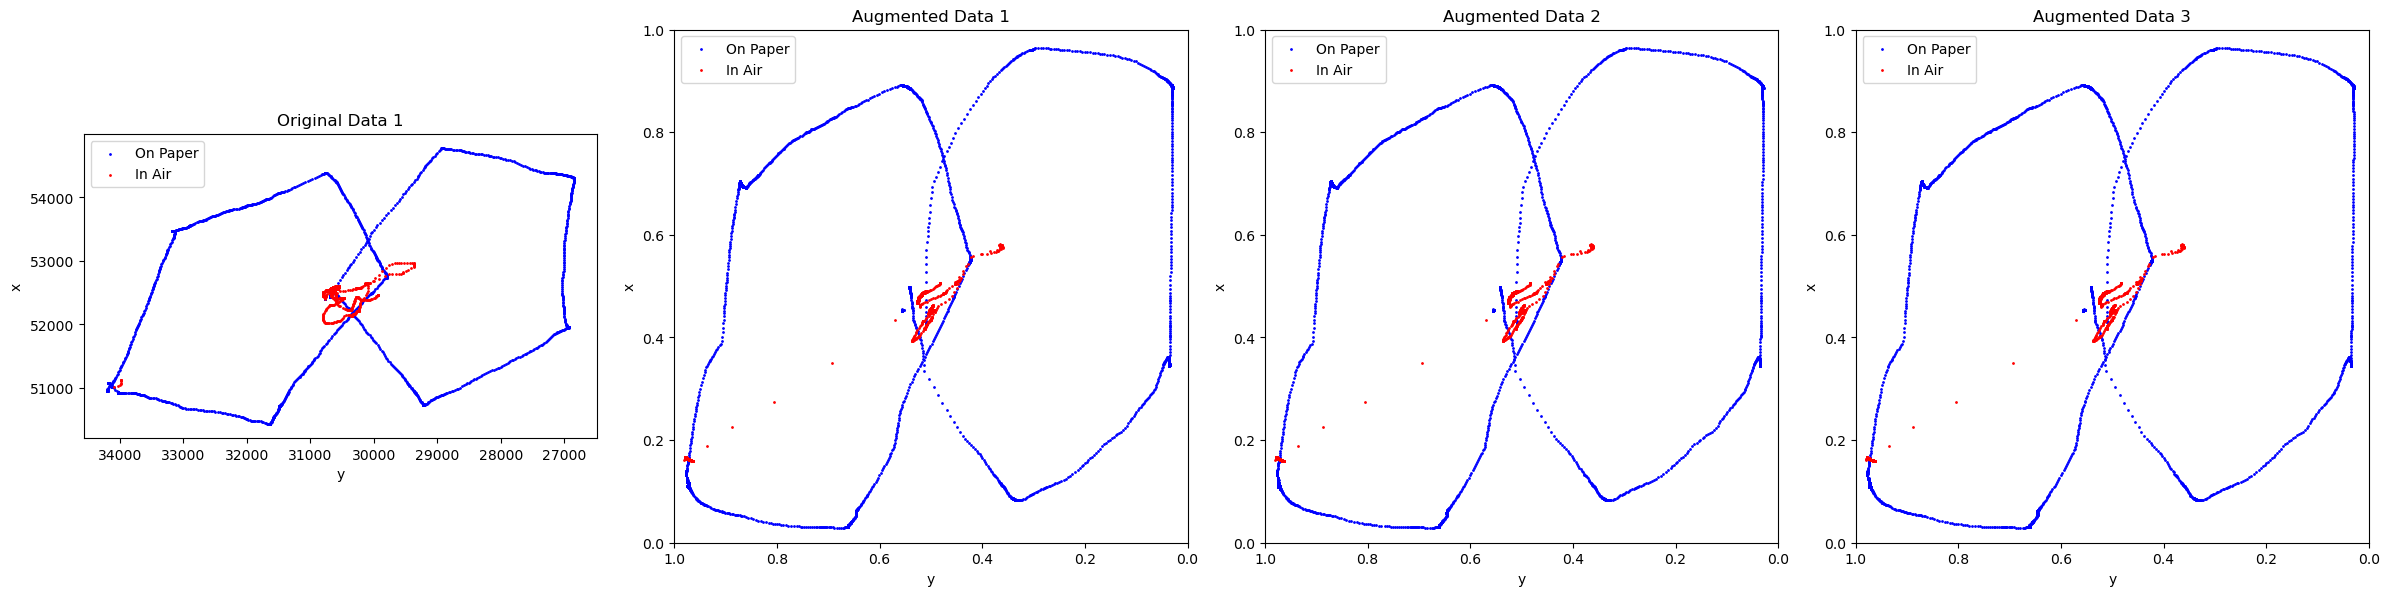

Final NRMSE: 0.299434
Training completed.
VAE model saved.


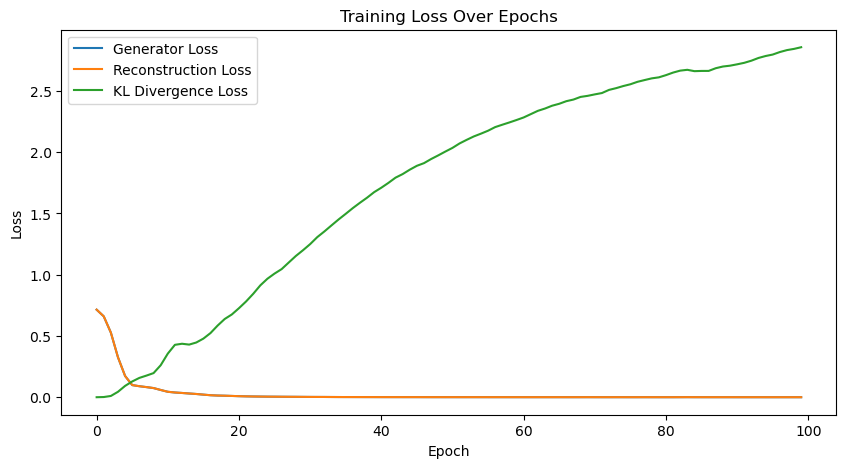

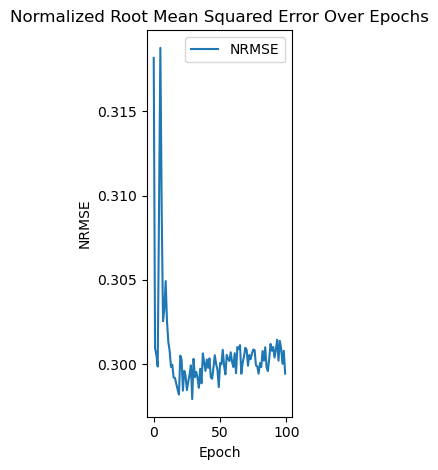

In [17]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss + 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 200
lstm_interval = 50
epochs = 100
visual_per_num_epoch = 100
num_augmented_files = 1

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                # Use LSTM discriminator after vae_epochs and every lstm_interval
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train the LSTM discriminator every lstm_interval epochs after vae_epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)  # Reshape for LSTM input
            generated_data = tf.expand_dims(augmented_data, axis=0)

            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')

    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")

    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)
        num_augmented_files = 3

        # Generate augmented data using the pretrained model
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                    base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        # Plot the original data before imputation, with a 90-degree left rotation and horizontal flip
        for i, original_data in enumerate(original_data_frames):  # Use original_data_frames for raw data visualization
            original_on_paper = original_data[original_data['pen_status'] == 1]
            original_in_air = original_data[original_data['pen_status'] == 0]
            
            # Scatter plot for the original data (before imputation), with rotated axes
            axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')  # y -> x, x -> y
            axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')  # y -> x, x -> y
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].set_xlabel('y')  # Previously 'x'
            axs[i].set_ylabel('x')  # Previously 'y'
            axs[i].set_aspect('equal')
            axs[i].legend()
            
            # Flip the horizontal axis (y-axis)
            axs[i].invert_xaxis()  # This reverses the 'y' axis to flip the plot horizontally

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        # Plot the augmented data with the same 90-degree left rotation and horizontal flip
        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            
            # Scatter plot for the augmented data, with rotated axes
            axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')  # y -> x, x -> y
            axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')  # y -> x, x -> y
            axs[i+len(original_data_frames)].set_title(f'Augmented Data {i+1}')
            axs[i+len(original_data_frames)].set_xlabel('y')  # Previously 'x'
            axs[i+len(original_data_frames)].set_ylabel('x')  # Previously 'y'
            axs[i+len(original_data_frames)].set_aspect('equal')
            axs[i+len(original_data_frames)].set_xlim(y_max, y_min)  # Reverse the 'y' axis for horizontal flip
            axs[i+len(original_data_frames)].set_ylim(x_min, x_max)  # Keep the vertical limits the same
            axs[i+len(original_data_frames)].legend()

        plt.tight_layout()
        plt.show()

# Final output of metrics
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

vae.save('pentab_saved_model.h5')
print("VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Cell 10 NRMSE
def calculate_nrmse(original, predicted):

    if original.shape != predicted.shape:
        raise ValueError("The shapes of the original and predicted datasets must match.")
    
    mse = np.mean((original - predicted) ** 2)
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(original) - np.min(original))
    
    return nrmse

# Example usage:
nrmse_values = []

# Using all_augmented_data from Cell 9
for i, (original, augmented) in enumerate(zip(data_frames, all_augmented_data)):
    original_array = original[['x', 'y', 'timestamp', 'pen_status']].values
    augmented_array = augmented[:, :4]  # Assuming first 4 columns match original data structure

    nrmse = calculate_nrmse(original_array, augmented_array)
    nrmse_values.append(nrmse)

# Print results
for i, nrmse in enumerate(nrmse_values):
    print(f"NRMSE for dataset {i+1}: {nrmse:.4f}")

# Calculate average NRMSE
average_nrmse = np.mean(nrmse_values)
print(f"Average NRMSE: {average_nrmse:.4f}")

In [23]:
# Cell 11 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_lstm_classifier(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_for_lstm(real_data, synthetic_data):
    # Determine the number of features to use (minimum of real and synthetic data)
    n_features = min(real_data.shape[1], synthetic_data.shape[1])
    
    # Trim the features to match
    real_data_trimmed = real_data[:, :n_features]
    synthetic_data_trimmed = synthetic_data[:, :n_features]
    
    X = np.vstack((real_data_trimmed, synthetic_data_trimmed))
    y = np.concatenate((np.ones(len(real_data)), np.zeros(len(synthetic_data))))
    return X, y

def post_hoc_discriminative_score(real_data, synthetic_data, n_splits=10):
    X, y = prepare_data_for_lstm(real_data, synthetic_data)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reshape the data for LSTM input (samples, timesteps, features)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = create_lstm_classifier((1, X_train.shape[2]))
        model.fit(X_train, y_train, epochs=3, batch_size=256, verbose=1)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    return mean_accuracy, std_accuracy

# Assuming 'processed_data' contains the real data and 'augmented_datasets' contains the synthetic data
real_data = np.concatenate(processed_data, axis=0)
synthetic_data = np.concatenate(augmented_datasets, axis=0)

print(f"Real data shape: {real_data.shape}")
print(f"Synthetic data shape: {synthetic_data.shape}")

mean_accuracy, std_accuracy = post_hoc_discriminative_score(real_data, synthetic_data)

print(f"\nPost-Hoc Discriminative Score Results:")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# Interpret the results
if abs(mean_accuracy - 0.5) < 0.05:
    print("\nThe synthetic data is effectively indistinguishable from real data.")
elif mean_accuracy > 0.55:
    print("\nThe classifier can distinguish between real and synthetic data with some accuracy.")
    print("This suggests that the synthetic data may not fully capture all characteristics of the real data.")
else:
    print("\nThe classifier performs worse than random guessing.")
    print("This might indicate issues with the classification process or highly varied data.")

Real data shape: (5971, 4)
Synthetic data shape: (17913, 7)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Post-Hoc Discriminative Score Results:
Mean Accuracy: 0.7500
Standard Deviation: 0.0050

The classifier can distinguish between real and synthetic data with some accuracy.
This suggests that the synthetic data may not fully capture all characteristics of the real data.


In [24]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

def prepare_data(data):
    """Prepare data for prediction (use all but last time step as input, last as target)."""
    X = data[:, :-1]  # All but last time step
    y = data[:, -1]   # Last time step
    return X, y

def post_hoc_predictive_score(synthetic_data, real_data, n_repeats=10):
    scaler = MinMaxScaler()
    synthetic_data_scaled = scaler.fit_transform(synthetic_data)
    real_data_scaled = scaler.transform(real_data)

    X_synthetic, y_synthetic = prepare_data(synthetic_data_scaled)
    X_real, y_real = prepare_data(real_data_scaled)

    mape_scores = []

    for _ in range(n_repeats):
        # Train on synthetic data
        model = LinearRegression()
        model.fit(X_synthetic, y_synthetic)

        # Predict on real data
        y_pred = model.predict(X_real)

        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_real, y_pred)
        mape_scores.append(mape)

    mean_mape = np.mean(mape_scores)
    std_mape = np.std(mape_scores)

    return mean_mape, std_mape

# Assuming 'processed_data' contains the real data and 'augmented_datasets' contains the synthetic data
real_data = np.concatenate(processed_data, axis=0)
synthetic_data = np.concatenate(augmented_datasets, axis=0)

# Ensure both datasets have the same number of features
min_features = min(real_data.shape[1], synthetic_data.shape[1])
real_data = real_data[:, :min_features]
synthetic_data = synthetic_data[:, :min_features]

mean_mape, std_mape = post_hoc_predictive_score(synthetic_data, real_data)

print(f"Post-Hoc Predictive Score Results:")
print(f"Mean MAPE: {mean_mape:.4f}")
print(f"Standard Deviation of MAPE: {std_mape:.4f}")

# Interpret the results
if mean_mape < 0.1:
    print("\nThe synthetic data captures the patterns of the original data very well.")
elif mean_mape < 0.2:
    print("\nThe synthetic data captures the patterns of the original data reasonably well.")
else:
    print("\nThe synthetic data may not fully capture the patterns of the original data.")
    print("Consider refining the data generation process.")

Post-Hoc Predictive Score Results:
Mean MAPE: 825373093097945.0000
Standard Deviation of MAPE: 0.0000

The synthetic data may not fully capture the patterns of the original data.
Consider refining the data generation process.


In [1]:
# Cell 9 (modified to retain augmented data length)
def download_augmented_data_as_integers(augmented_datasets, scalers, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        # If augmented data is longer, extend original_paa by repeating the last row
        if len(augmented_data) > len(original_paa):
            last_row = original_paa[-1:]
            repeat_count = len(augmented_data) - len(original_paa)
            extended_rows = np.tile(last_row, (repeat_count, 1))
            original_paa = np.vstack((original_paa, extended_rows))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Combine all data
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

# Example call to the function
download_augmented_data_as_integers(augmented_datasets, scalers, original_data_frames, input_filenames)

# Add this diagnostic print statement after generating augmented_datasets
print("Shapes of augmented datasets:")
for i, aug_data in enumerate(augmented_datasets):
    print(f"Shape of augmented dataset {i+1}: {aug_data.shape}")

NameError: name 'augmented_datasets' is not defined

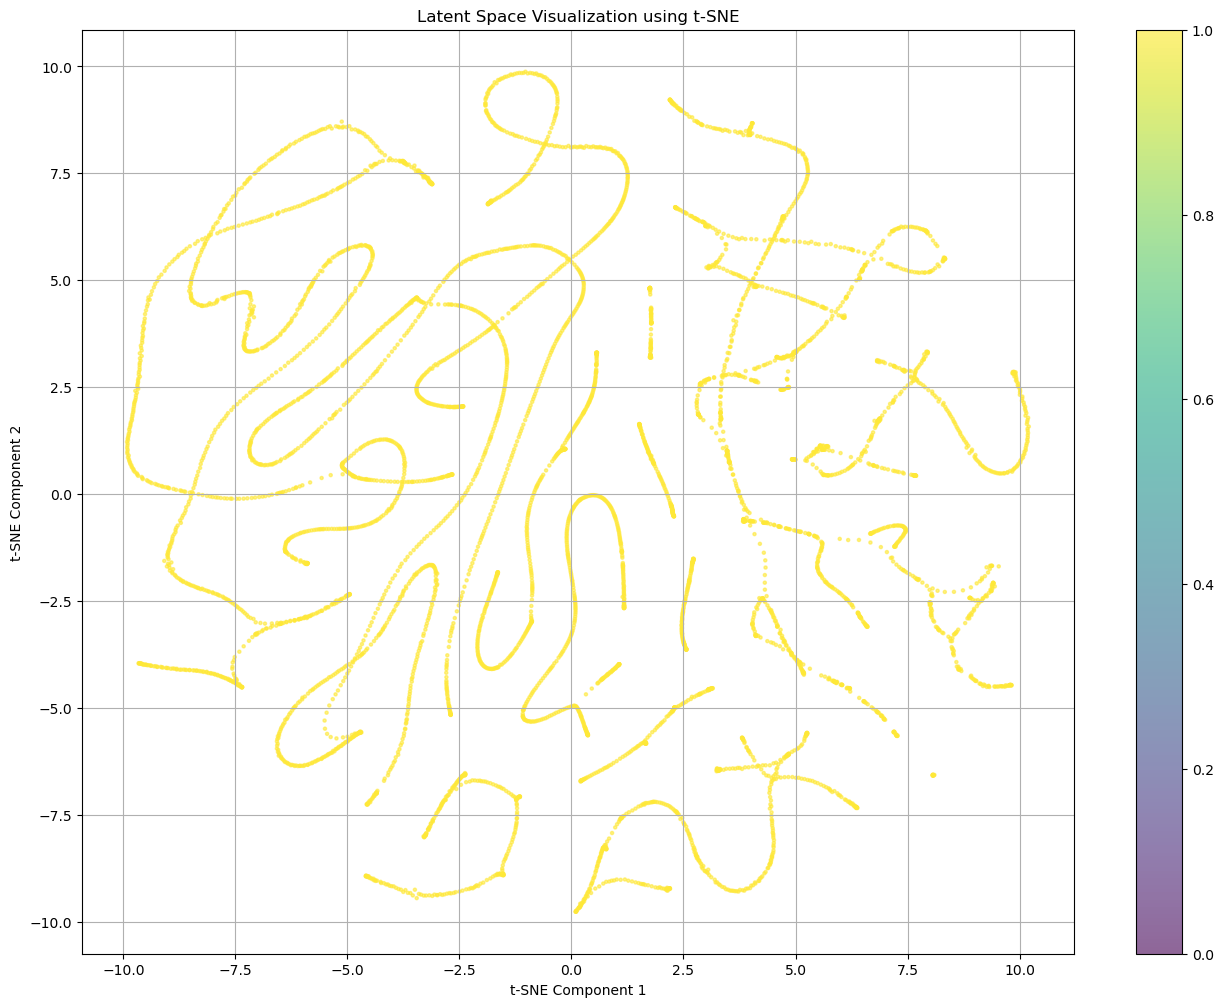

In [22]:
#Cell 11 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])